In [1]:
# magics: ensures that any changes to the modules loaded below will be re-loaded automatically
%load_ext autoreload
%autoreload 2

import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import copy
import scipy.optimize as optimize

from mytest import child_model
import NPL
from Solve_NFXP import solve_NFXP
import estimate_NFXP as estimate
import estimate_NFXP_copy as estimate_c
#import back as back



In [2]:
model = child_model()
model.p

array([0.3, 0.7])

In [3]:
solver = solve_NFXP()
ev,pk = solver.poly(model.bellman, beta = model.beta, output=2)

# data
data = model.sim_data(pk)
samplesize = data.shape[0]
print(pk, ev)
data
model.p

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 1 is different from 5)

In [5]:
tabulate = data.dx1.value_counts()
tabulate


0    14064
1     5936
Name: dx1, dtype: int64

In [7]:
print('Model grid:\n',model.grid)
print('Transition probabilities conditional on no contraception:\n',model.P1)
print('Transition probabilities conditional on contraception:\n',model.P2)
ev,pk, dev = model.bellman(np.zeros((model.n)),output=3)
print('Bellman one run:\n',ev)
print('Bellman pk:\n',pk)


Model grid:
 [0 1 2 3 4]
Transition probabilities conditional on no contraception:
 [[0.3 0.7 0.  0.  0. ]
 [0.  0.3 0.7 0.  0. ]
 [0.  0.  0.3 0.7 0. ]
 [0.  0.  0.  0.3 0.7]
 [0.  0.  0.  0.  1. ]]
Transition probabilities conditional on contraception:
 [[0.97 0.03 0.   0.   0.  ]
 [0.   0.97 0.03 0.   0.  ]
 [0.   0.   0.97 0.03 0.  ]
 [0.   0.   0.   0.97 0.03]
 [0.   0.   0.   0.   1.  ]]
Bellman one run:
 [ 0.55761079  0.24417857 -0.3593131  -1.25317481 -1.54747653]
Bellman pk:
 [0.52996405 0.47976106 0.42996352 0.38154397 0.33536913]


In [8]:
datad0 = data[data['d']==0]
datad1 = data[data['d']==1]

tabulate0 = datad0.dx1.value_counts()
tabulate1 = datad1.dx1.value_counts()
p = [tabulate0[i]/sum(tabulate0) for i in range(tabulate0.size-1)]
p2 = [tabulate1[i]/sum(tabulate1) for i in range(tabulate1.size-1)]
print(p,p2)


[0.30405573525752677] [0.9714094633004514]


In [27]:
model = child_model()

In [28]:
# Find tha likelihood value for different combinations 

par_mu = copy.copy(model.mu)
par_eta2 = copy.copy(model.eta2)

NRC = 50
Nc = 50

log_lik = np.nan + np.zeros((NRC,Nc))
mu= np.linspace(-1,1,NRC)
eta2 = np.linspace(-1,1,Nc)

for i in range(NRC):
    for j in range(Nc):
       
        # STEP 1: Find p 
        #datad0 = data[data['d']==0]
        #datad1 = data[data['d']==1]
    
        #tabulate0 = datad0.dx1.value_counts()
        #tabulate1 = datad1.dx1.value_counts()
        #p = [tabulate0[i]/sum(tabulate0) for i in range(tabulate0.size-1)]
        #p2 = [tabulate1[i]/sum(tabulate1) for i in range(tabulate1.size-1)]
        
        # STEP 2: Estimate structual parameters
        #model.p = p # Use first step estimates as starting values for t
        #model.p2 = p2
        # Estimate RC and C
        pnames = ['mu','eta2']
        theta = np.array([mu[i], eta2[j]])
        log_lik[i,j]=estimate_c.ll(theta,model, solver,data, pnames)

log_lik *= samplesize*(-1)

#Re-inset the true parameters 
model.mu = copy.copy(par_mu)
model.eta2 = copy.copy(par_eta2)

print(model.mu, model.eta2)

-0.12 0.15


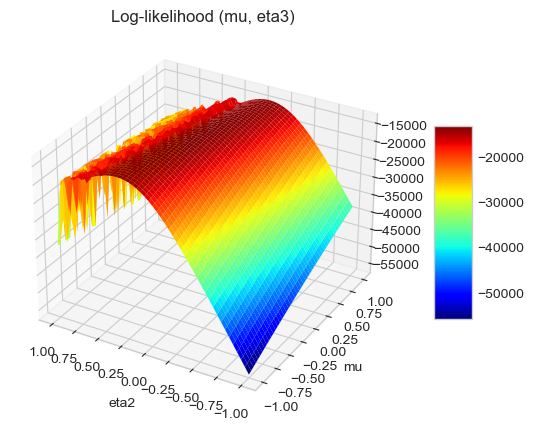

In [29]:
# plot figure in three dimensions
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
plt.style.use('seaborn-whitegrid')


fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(1,1,1,projection='3d')

# Make data.
X, Y = np.meshgrid(eta2, mu)

# Plot the surface.
surf = ax.plot_surface(X, Y, log_lik, cmap=cm.jet)

# Customize the axis.
ax.set_xlabel(f'eta2')
ax.set_ylabel(f'mu')
ax.set_title(f'Log-likelihood (mu, eta3)')
ax.invert_xaxis()

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

In [48]:

theta0 = [0.0,0.0]

# Estimate
nfxp_model, nfxp_results, pnames, theta_hat, Avar, converged = estimate_c.estimate(model, solver, data, theta0=theta0)

# Print 
print(f'Log-Likelihood:     {-nfxp_results.fun*samplesize:.4f}')
print(f'mu:                 {theta_hat[0]:.4f}')
print(f'eta2:               {theta_hat[1]:.4f}')
#print(f'eta3:               {theta_hat[2]:.4f}')


print(nfxp_model, nfxp_results, pnames, theta_hat, Avar, converged)
print(f'The model converged: {converged}')

model.eta2


/Users/carolinebergholdthansen/Desktop/Dynamic programming/dynamic_cbjk/estimate_NFXP_copy.py:144: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  


Log-Likelihood:     -32379.4048
mu:                 -0.0013
eta2:               -0.0242
<mytest.child_model object at 0x7f8dab095820>      fun: 1.6189702402266668
    hess: array([[  0.18677401,   4.01118526,  -0.44390612],
       [  4.01118526, 116.14630282,  -6.57086107],
       [ -0.44390612,  -6.57086107,   5.87334238]])
     jac: array([ 0.09818057,  2.61599315, -0.91916906])
 message: 'A bad approximation caused failure to predict improvement.'
    nfev: 29
    nhev: 3
     nit: 29
    njev: 3
  status: 2
 success: False
       x: array([-0.00126502, -0.02420282,  0.32129143]) ['mu', 'eta2', 'p'] [-0.00126502 -0.02420282  0.32129143] [[ 1.25983104e-03 -4.06980958e-05  4.96863887e-05]
 [-4.06980958e-05  1.77430747e-06 -1.09093007e-06]
 [ 4.96863887e-05 -1.09093007e-06  1.10478392e-05]] True
The model converged: True


-0.024202816599090356

In [47]:
theta0 = [0.1,0.1,0.1]
model = child_model()


# Estimate
nfxp_model, nfxp_results, pnames, theta_hat, Avar, converged = estimate.estimate(model, solver, data, theta0=theta0, twostep=2)

# Print 
print(f'Log-Likelihood:     {-nfxp_results.fun*samplesize:.4f}')
print(f'mu:                 {theta_hat[0]:.4f}')
print(f'eta2:               {theta_hat[1]:.4f}')
print(f'eta3:               {theta_hat[2]:.4f}')


print(nfxp_model, nfxp_results, pnames, theta_hat, Avar, converged)

Log-Likelihood:     -13292.4828
mu:                 0.1000
eta2:               0.1000
eta3:               0.1000
<mytest.child_model object at 0x7f8dab095820>      fun: 0.6646241400479493
    hess: array([[1.47295901e-01, 3.99110795e-01, 7.98221590e-02],
       [3.99110795e-01, 1.21509167e+02, 2.43018333e+01],
       [7.98221590e-02, 2.43018333e+01, 4.86036666e+00]])
     jac: array([-0.00679493, -0.50523727, -0.10104745])
 message: 'A bad approximation caused failure to predict improvement.'
    nfev: 26
    nhev: 1
     nit: 27
    njev: 1
  status: 2
 success: False
       x: array([0.1, 0.1, 0.1]) ['mu', 'eta2', 'eta3'] [0.1 0.1 0.1] [[ 3.42500999e-04  1.47979148e-03 -7.41598507e-03]
 [ 1.48906526e-03 -6.30453915e+08  3.15226957e+09]
 [-7.45095122e-03  3.15226957e+09 -1.57613479e+10]] True


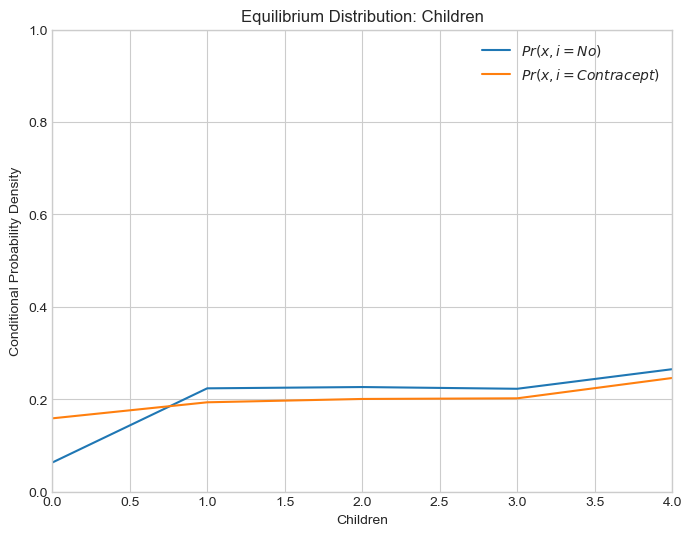

In [13]:
# Update the values with the estimated parameters
# do_settings = {
#     'n': 900,
#     'mu': -0.12,
#     'eta2': 0.15,
#     'eta3': -0.05,
#     'p': model.p
# }



ev,pk = solver.poly(model.bellman, beta = model.beta, output=2)

# Find the probability functions
pp, pp_K, pp_R = model.eqb(pk)

fig = plt.figure(figsize=(8,6)) 
ax = fig.add_subplot(1,1,1)

ax.plot(model.grid*(model.max)/model.n,pp_K/sum(pp_K))
ax.plot(model.grid*(model.max)/model.n,pp_R/sum(pp_R))


ax.set_title(f'Equilibrium Distribution: Children')
ax.set_xlabel("Children")
ax.set_ylabel("Conditional Probability Density")
ax.set_xlim(0, 4)
ax.set_ylim(0, 1)

plt.legend((f'$Pr(x, i=No)$',f'$Pr(x, i=Contracept)$'))

plt.show()

In [ ]:
tmp = model.P1[:,1:model.n] * pk[1:model.n]
pl = np.hstack(((1-np.sum(tmp,1,keepdims=True)), tmp))
print(pl)

model.P1*pk

In [ ]:

 


pp = model.ergodic(pl)

pp_K = pp.copy()    
pp_K[0] = model.p[0]*pp[0]*pk[0]
pp_R = (1-pk)*pp # Vær opmærksom på at dette måske skal ændres hvis sandsynligheden for uønsket børn ændre sig

#ergodic.m: finds the invariant distribution for an NxN Markov transition probability: q = qH , you can also use Succesive approximation
n = p.shape[0]
if n != p.shape[1]:
print('Error: p must be a square matrix')
ed = np.nan
else:
ap = np.identity(n)-p.T
ap = np.concatenate((ap, np.ones((1,n))))
ap = np.concatenate((ap, np.ones((n+1,1))),axis=1)

# find the number of linearly independent columns
temp, _ = np.linalg.eig(ap)
temp = ap[temp==0,:]
rank = temp.shape[1]
if rank < n+1:
    print('Error: transition matrix p is not ergodic')
    ed = np.nan
else:
                ed = np.ones((n+1,1))
                ed[n] *=2
                ed = np.linalg.inv(ap)@ed
                ed = ed[:-1]
                ed = np.ravel(ed)

        return ed


In [ ]:
import copy
mp0 = copy.copy(model.mu)
NRC = 200

RCgrid = np.linspace(-10,10,NRC)
Demand = np.empty(NRC)

for i,val in enumerate(RCgrid):
    do_settings = {
        'n': 1000,
        'RC': val,
        'c': model.eta2,
    }
    
    model = child_model(**do_settings)
    _,pk = solver.poly(model.bellman, beta= model.beta, output=2)

    # Find the probability functions
    pp, pp_K, pp_R = model.eqb(pk)
    
    Demand[i] = 1000*sum(pp_R)

fig = plt.figure(figsize=(8,6)) 
ax2 = fig.add_subplot(1,1,1)
ax2.plot(RCgrid,Demand)
ax2.set_title(f'Expected Replacement Demand Function')
ax2.set_xlabel("Replacement cost, RC")
ax2.set_ylabel("Expected Annual Engine Replacement")
ax2.set_xlim(-10,10)
ax2.set_ylim(0,1000)

plt.show()

In [44]:
print(model.p)
np.abs(model.p)


[0.7032 0.2968]


array([0.7032, 0.2968])

In [ ]:
model = child_model()

In [ ]:
import numpy as np
from types import SimpleNamespace
import scipy.optimize as optimize

m_max =4
m_antal =5
m_min = 0
D = 2
T = 25

def util(m,d,model):
    return model.eta2*m + model.eta3*(m**2) + model.mu*d


def solve_last_period():

    # a. allocate
    c_grid = np.linspace(m_min,m_max,m_antal)
    v_func = np.empty(m_antal)
    dec = np.linspace(0,1,1)
    d_func = np.empty(2)

    # b. solve
    for i,m in enumerate(c_grid):
        for j,d in enumerate(dec):
        # i. objective
            v = util(m,d,model)
        
            # iii. save
            v_func[i] = v
            d_func[j] = d
        
    return c_grid,v_func,d_func

solve_last_period()

In [ ]:
for m in range(4):
    for d in range(2):
        v = util(m,d,model)
        print(m,d,v)


